# Big Data Project
Buongiorno a tutti

In [1]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("Spark ML example on Credit Card data") \
    .getOrCreate()

21/10/13 16:33:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Lettura del file da hdfs con spark e conteggio delle colonne con valori nulli/NaN

In [2]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

nullValues = dataSet.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataSet.columns])
nullValues.show()

21/10/13 16:33:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Convertiamo in Pandas per una gestione più semplice per poter fare i grafici

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

Grafico X: Amount --> Y: Class

In [ ]:
X = df['Amount']
Y = df['Class']

plt.style.use('seaborn-whitegrid')
plt.xlabel("Amount")
plt.ylabel("Class")
plt.scatter(X, Y, marker = ".", color = 'red')
plt.show()

È possibile dedurre che il dataset è sbilanciato e che le transazioni con class = 1 (frodi) hanno un valore di Amount relativamente basso (< 5000).

Grafico: X: Time -- Y:Amount (Rosso frode - Blu non frode)

In [ ]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.show()

#Grafico frode
X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.scatter(X, Y, marker = ".", color = "red")
plt.show()

Secondo me (Davide) è possibile fare discorsi sulla colonna Time, eliminabile a prescindere

In [ ]:
import seaborn as sns

# shuffle before creating subsamples

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

soglia = 0.05
print(corr["Class"] < soglia)

Calcolo matrice di covarianza per capire quali attributi è possibile eliminare

In [ ]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

from sklearn import preprocessing

minMaxScaler = preprocessing.MinMaxScaler()
scaledTime = minMaxScaler.fit_transform(dfFinal[['Time']])
scaledAmount = minMaxScaler.fit_transform(dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

dfFinal = dfFinal.drop(['Time', 'Amount'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test,y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

In [ ]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

from sklearn import preprocessing

standardScaler = preprocessing.StandardScaler()
scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

#ELIMINO V26 PERCHè NELLA MATRICE DI CORRELAZIONE DEL PASSO SUCCESSIVO, V26 è MINORE DI 0.05
dfFinal = dfFinal.drop(['Time', 'Amount', 'V26', 'ScaledTime'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

#hidden_layer_sizes=(200,)
MLPC = MLPClassifier(hidden_layer_sizes=(200, 26), max_iter=10000, activation="tanh", verbose=True)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test, y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

Divisione del dataset in training set e validation set

In [ ]:
# shuffle before creating subsamples

df_fraud = dfFinal.loc[dfFinal.Class == 1]
df_non_fraud = dfFinal.loc[dfFinal.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

print(corr["Class"] <= 0.05)

Creazione del modello di predizione

Valutazione dell'errore del modello ottenuto al passo precedente

In [25]:
from skfeature.function.similarity_based import fisher_score

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][0:492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

fisherX = np.array(dfFifty.iloc[:, dfFifty.columns != 'Class'])
fisherY = np.array(dfFifty.iloc[:, dfFifty.columns == 'Class'])
fisherY = fisherY.reshape(1, -1)[0]

idx = fisher_score.fisher_score(fisherX, fisherY) #returns rank directly instead of fisher score. so no need for feature_ranking
idx = fisher_score.feature_ranking(idx)
print(idx)

492
[ 0 14 12  4 11 10  3 16  9 17  7  2  6 18  1  5 19 15 20 21 29 28 24 27
 25  8 26 22 13 23]


In [ ]:
dfFinal = df.drop(["Time", "V3", "V6", "V11", "V14"], axis = 1) # <-- dal fisher score
dfFinal = dfFinal.drop(["V13", "V23"], axis = 1) # <-- dalla matrice di correlazione

from sklearn import preprocessing

standardScaler = preprocessing.StandardScaler()
scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

dfFinal = dfFinal.drop(['Time', 'Amount', 'ScaledTime'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

#hidden_layer_sizes=(200,)
MLPC = MLPClassifier(hidden_layer_sizes=(200,6), max_iter=10000, verbose=True)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test, y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

In [ ]:
#F1 score
from sklearn.metrics import f1_score
f1result = f1_score(y_test, y_pred)
print(f1result)

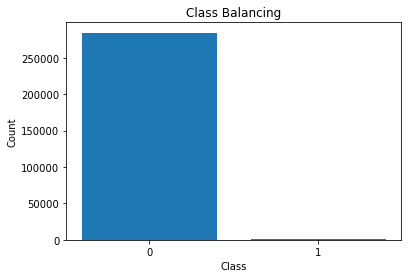

In [35]:
dfFinal = df.drop(["Time", "V3", "V6", "V11", "V14"], axis = 1) # <-- dal fisher score
dfFinal = dfFinal.drop(["V13", "V23"], axis = 1) # <-- dalla matrice di correlazione

#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

features = dfFinal[dfFinal.columns[:len(dfFinal.columns)-1]].to_numpy()
targets = dfFinal.Class.to_numpy()
#features, targets = SMOTE().fit_resample(features,targets)
#targets = targets.reshape(-1,1)

target_un,count = np.unique(targets,return_counts=True)
plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([str(i) for i in target_un],count)
plt.show()



Train Feature size :  199364
Train Label size   : 199364
Test Feature size  : 85443
Test Label size    : 85443
151


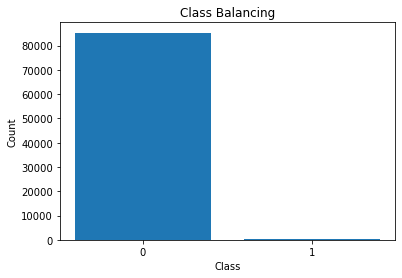

In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(features, targets, test_size=0.3, shuffle=True)

print("Train Feature size : ", len(X_train))
print("Train Label size   :", len(Y_train))
print("Test Feature size  :", len(X_test))
print("Test Label size    :", len(Y_test))

X_train, Y_train = SMOTE().fit_resample(X_train,Y_train)
Y_train = Y_train.reshape(-1,1)

In [44]:
model = RandomForestClassifier(n_estimators=100, criterion="entropy")
model.fit(X_train, Y_train)

/var/folders/9j/nybdj3kn5lnc_91_n44zs8240000gn/T/ipykernel_56447/1070773811.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)


RandomForestClassifier(criterion='entropy')

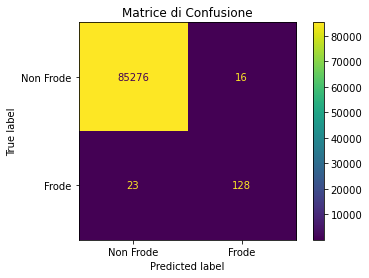

Train score     : 100.00 %
Test score      : 99.95 %
Accuratezza riconoscimento frodi : 84.77 %
Accuratezza riconoscimento non frodi : 99.98 %
Recall score sul test set     : 88.89 %


In [56]:
trainPredetto = model.predict(X_train)
testPredetto = model.predict(X_test)

cm = confusion_matrix(Y_test, testPredetto, labels=[0, 1])

cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Frode","Frode"])
cmatrix.plot()
plt.title("Matrice di Confusione")
plt.show()

veriNegativi = cm[0][0]
veriPositivi = cm[1][1]
falsiPositivi = cm[0][1]
falsiNegativi = cm[1][0]

nonFrodiTotali = veriNegativi + falsiPositivi
frodiTotali = veriPositivi + falsiNegativi

percentualeDiSuccessoNonFrodi = veriNegativi / nonFrodiTotali
percentualeDiSuccessoFrodi = veriPositivi / frodiTotali

print("Train score     : {:.2f} %".format(accuracy_score(trainPredetto, Y_train) * 100))
print("Test score      : {:.2f} %".format(accuracy_score(testPredetto, Y_test) * 100))
print("Accuratezza riconoscimento frodi : {:.2f} %".format(percentualeDiSuccessoFrodi*100))
print("Accuratezza riconoscimento non frodi : {:.2f} %".format(percentualeDiSuccessoNonFrodi*100))

from sklearn.metrics import recall_score
print("Recall score sul test set     : {:.2f} %".format(recall_score(testPredetto, Y_test) * 100))

In [57]:
print(frodiTotali + nonFrodiTotali)

85443
